In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import pandas as pd

from keras.layers import Embedding, GlobalAveragePooling1D, Dropout, Dense, TextVectorization, Activation, GlobalMaxPooling1D
from keras.losses import SparseCategoricalCrossentropy
from keras.models import Model
from keras.callbacks import EarlyStopping

url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')


6062080/6053168 [==============================] - 0s 0us/step


In [2]:
# region Process Data
batch_size = 32
seed = 42

train_dataset = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

print('\n')
print("Label 0 corresponds to", train_dataset.class_names[0])
print("Label 1 corresponds to", train_dataset.class_names[1])
print("Label 2 corresponds to", train_dataset.class_names[2])
print("Label 3 corresponds to", train_dataset.class_names[3])
print('\n')

validation_dataset = tf.keras.utils.text_dataset_from_directory(
    'train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

test_dataset = tf.keras.utils.text_dataset_from_directory(
    'test',
    batch_size=batch_size)
# endregion

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second co

In [5]:
# region Standardize, Tokenize and Vectorize
"""Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the 
dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual 
words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a 
neural network. """


def CustomStandardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')


max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=CustomStandardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels), then call adapt
train_text = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


def VectorizeText(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(train_dataset))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", train_dataset.class_names[first_label])
print("Vectorized review", VectorizeText(first_review, first_label))

print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print("313 ---> ", vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))
# endregion

# region Apply text vectorization on the datasets
train_data = train_dataset.map(VectorizeText)
val_data = validation_dataset.map(VectorizeText)
test_data = test_dataset.map(VectorizeText)
# endregion

# region Configure data for performance
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)
# endregion

# region Create the model
embedding_dim = 16

# embed_layer = Embedding(max_features + 1, embedding_dim)
# dropout_layer_1 = Dropout(0.2)(embed_layer)
# pooling_layer = GlobalAveragePooling1D()(dropout_layer_1)
# dropout_layer_2 = Dropout(0.2)(pooling_layer)
# hidden_layer = Dense(units=1)(dropout_layer_2)

model = tf.keras.Sequential([
  Embedding(max_features + 1, embedding_dim),
  Dropout(0.2),
  GlobalAveragePooling1D(),
  #Dense(units=12, activation='relu'),
  #GlobalMaxPooling1D(),
  Dropout(0.2),
  Dense(units=4)])

model.summary()

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
# endregion

# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)

# region Train and evaluate the model
epochs = 30
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[early_stop])

loss, accuracy = model.evaluate(test_data)

print("Loss: ", loss)
print("Accuracy: ", accuracy)
# endregion

Review tf.Tensor(b'"what is an efficient way operating a set of variables? i am making a ""genetic simulator"", and at some point i want to compare the data in the genes to set the result in an individual. i came to a solution, but seems quite impractical, i\'m sure there is a proper way of doing it ..right now, i use a static method in a support class that handles the operation, but i fear that maintenance will be annoying, as i plan to modify the list of attributes quite often...public class geneops {  .    public static attributelist addattributelists (attributelist a, attributelist b) {.        attributelist x=new attributelist();..        x.agressiveness= a.agressiveness+b.agressiveness;.        x.bravery=a.bravery+b.bravery;.        x.speed=a.speed+b.speed;.        //repeat for all attributes..        return x;.    }.}...this works, but i would like something that is updated automatically every time i decide to add something to the list eg: if i add an attribute called sneak, i w

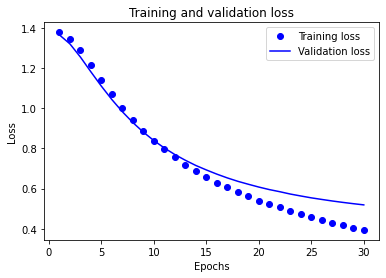

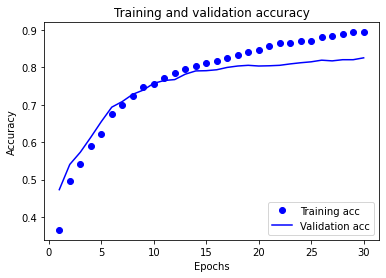

In [6]:
# region Plot the graph
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()
# endregion

In [7]:
# Retrain with activation and vector layer
optimized_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  Activation('softmax')
])

optimized_model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `test_dataset`, which yields raw strings
loss, accuracy = optimized_model.evaluate(test_dataset)
print(accuracy)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


250/250 [==============================] - 3s 11ms/step - loss: 0.5697 - accuracy: 0.7947
0.7947499752044678
